In [1]:
from datetime import datetime
import dask.array as da
import os
import time
import h5py
import numpy as np
import xarray as xr
import downscale as down

import cartopy
import cartopy.feature as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite','IMERG','IMERG_Italy_1dy_2000_06_01_2024_02_29_veneto_R2.nc')
DATA = xr.open_dataset(data_dir)
DATA = DATA.sel(time=DATA.time.dt.year.isin([np.arange(2001,2010+1)]))

lons = DATA.lon.values
lats = DATA.lat.values

lon2d_ref, lat2d_ref = np.meshgrid(lons, lats)

nlon_ref = np.size(lons)
nlat_ref = np.size(lats)

dx = np.abs(lons[1] - lons[0])
dy = np.abs(lats[1] - lats[0])

ntime = len(DATA['time'])

DATA

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 3652, lat: 10, lon: 10)
Coordinates:
  * time     (time) datetime64[ns] 29kB 2001-01-01 2001-01-02 ... 2010-12-31
  * lat      (lat) float64 80B 45.55 45.65 45.75 45.85 ... 46.25 46.35 46.45
  * lon      (lon) float32 40B 12.05 12.15 12.25 12.35 ... 12.75 12.85 12.95
Data variables:
    PRE      (time, lat, lon) float64 3MB ...
Attributes:
    description:  IMERG daily data for Italy region

In [14]:
lon_d = np.arange(np.round(np.sort(lons)[0]+dx/2,2),np.round(np.sort(lons)[-2]+dx/2,2), dx/2)
lat_d = np.arange(np.round(np.sort(lats)[0]+dy/2,2),np.round(np.sort(lats)[-2]+dy/2,2), dy/2)
lon2d_d, lat2d_d = np.meshgrid(lon_d, lat_d)

nlat = len(lat_d)
nlon = len(lon_d)

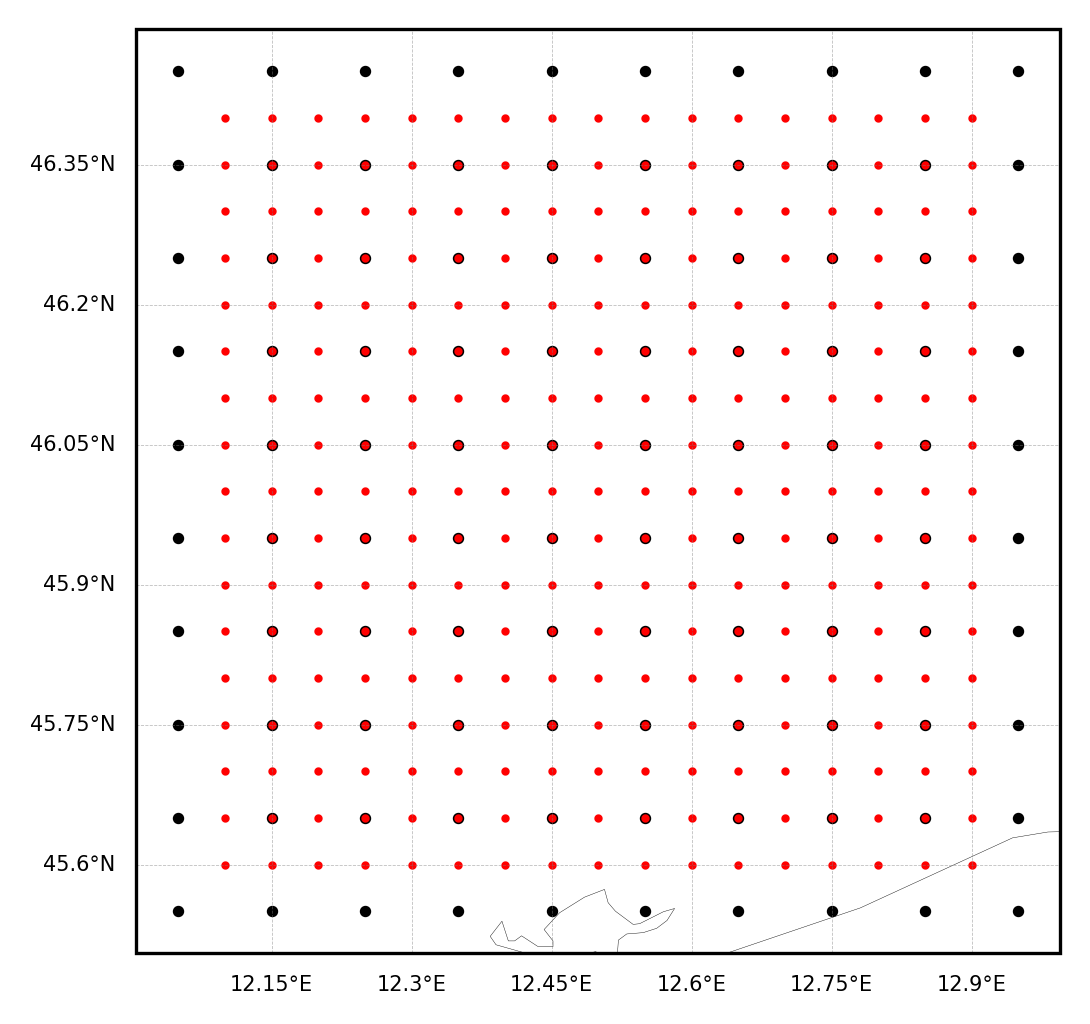

In [15]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([10, 13.5, 44.5, 47], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
# a1 = ax1.contourf(lon2d_ref, lat2d_ref, np.mean(DATA['PRE'].values,axis=0), cmap=cmap)
ax1.scatter(lon2d_ref, lat2d_ref, s=3, c='k')
ax1.scatter(lon2d_d, lat2d_d, s=1, c='r')

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# cbar = plt.colorbar(a1, fraction=0.033)
# cbar.ax.tick_params(labelsize=5)

In [16]:
thresh = 1
acf = 'mar'
toll=0.005
opt_method='genetic'
# dt = 3
Tr = np.array([1, 2, 5, 10, 20, 50, 100])
nyears = len(Tr)

## 309 minutos aprox

In [22]:
MEV_d_matrix = np.zeros([nyears, nlat, nlon])
MEV_s_matrix = np.zeros([nyears, nlat, nlon])

NYs_matrix = np.zeros([10, nlat, nlon])
CYs_matrix = np.zeros([10, nlat, nlon])
WYs_matrix = np.zeros([10, nlat, nlon])
NYd_matrix = np.zeros([10, nlat, nlon])
CYd_matrix = np.zeros([10, nlat, nlon])
WYd_matrix = np.zeros([10, nlat, nlon])

Nd_matrix = np.zeros([nlat, nlon])
Cd_matrix = np.zeros([nlat, nlon])
Wd_matrix = np.zeros([nlat, nlon])
Ns_matrix = np.zeros([nlat, nlon])
Cs_matrix = np.zeros([nlat, nlon])
Ws_matrix = np.zeros([nlat, nlon])
eps_s_matrix = np.zeros([nlat, nlon])
alp_s_matrix = np.zeros([nlat, nlon])
eps_d_matrix = np.zeros([nlat, nlon])
alp_d_matrix = np.zeros([nlat, nlon])
gam_d_matrix = np.zeros([nlat, nlon])
gam_s_matrix = np.zeros([nlat, nlon])
beta_matrix = np.zeros([nlat, nlon])
QUANTILE = np.zeros([ntime, nlat, nlon])
RAIN_D = np.zeros([ntime, nlat, nlon])

npix = 3

count = 0
for i in range(nlat):
    for j in range(nlon):
        clat = lat2d_d[i,j]
        clon = lon2d_d[i,j]
        L1 = down.area_lat_long(clat, clon, dy, dx)[0] # in Km
        
        tmpalat = DATA['lat'][:]
        tmpalon = DATA['lon'][:]
        dates = DATA['time'][:]
        dset = np.swapaxes(DATA['PRE'],0,2).data[:,:,:]
        xrs0 = xr.DataArray(dset,  coords={'lon':tmpalon, 'lat':tmpalat, 'time':dates},
                                                    dims=('lon', 'lat', 'time'))
        xrs = xrs0.where(xrs0 >= -0.001)

        buffer = 0.50*npix*dx
        eps = 1e-4 # to make sure to include boundaires -> add an eps buffer
        solat = clat - buffer + eps
        nolat = clat + buffer + eps
        ealon = clon + buffer + eps
        welon = clon - buffer + eps
        bcond = np.logical_and(
                    np.logical_and( xrs.lat > solat, xrs.lat < nolat),
                    np.logical_and( xrs.lon > welon, xrs.lon < ealon))

        box_3h = xrs.where(bcond, drop = True).load()
        
        downres = down.downscale(box_3h, Tr, thresh=thresh, L0=0.001, dt=24,
                            toll=toll, tscale=24,
                            acf=acf, save_yearly=True,
                            maxmiss=100, clat=clat, clon=clon,
                            opt_method=opt_method, plot=True)
        
        MEV_d_matrix[:,i,j] = downres['mev_d']
        MEV_s_matrix[:,i,j] = downres['mev_s']
        
        NYs_matrix[:,i,j] = downres['NYs']
        CYs_matrix[:,i,j] = downres['CYs']
        WYs_matrix[:,i,j] = downres['WYs']
        NYd_matrix[:,i,j] = downres['NYd']
        CYd_matrix[:,i,j] = downres['CYd']
        WYd_matrix[:,i,j] = downres['WYd']
        
        Nd_matrix[i,j] = downres['Nd']
        Cd_matrix[i,j] = downres['Cd']
        Wd_matrix[i,j] = downres['Wd']
        Ns_matrix[i,j] = downres['Ns']
        Cs_matrix[i,j] = downres['Cs']
        Ws_matrix[i,j] = downres['Ws']
        eps_s_matrix[i,j] =downres['eps_s'] 
        alp_s_matrix[i,j] = downres['alp_s']
        eps_d_matrix[i,j] = downres['eps_d']
        alp_d_matrix[i,j] = downres['alp_d']
        gam_d_matrix[i,j] = downres['gam_d']
        gam_s_matrix[i,j] = downres['gam_s']
        beta_matrix[i,j] = downres['beta']
        
        Ti = np.linspace(1,100,box_3h.shape[2])
        Fi = 1 - 1/Ti
        qq = down.mev_quant(Fi, 1, downres['Nd'], downres['Cd'], downres['Wd'], thresh=1)[0]
        QUANTILE[:,i,j] = qq/np.nanmax(qq)
        
        RAIN_D[:,i,j] = box_3h[1,1,:].data * qq/np.nanmax(qq)
        print()

Downscaling Intermittency
Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 8.050327660482541e-05
differential_evolution step 2: f(x)= 8.050327660482541e-05
differential_evolution step 3: f(x)= 8.050327660482541e-05
Polishing solution with 'L-BFGS-B'
integration domain is zero
Downscaling pdf - global Weibull parameters
Downscaling pdf - yearly Weibull parameters

Downscaling Intermittency
Taylor_Beta WARNING: not enough accuracy!
the time resolution of the coarse data might not be enough!
or try to increase the value of interp
Downscaling the correlation
Computing the correlation
differential_evolution step 1: f(x)= 9.94679091055196e-05
differential_evolution step 2: f(x)= 9.94679091055196e-05
differential_evolution step 3: f(x)= 8.355181071935596e-05
differential_evolution step 4: f(x)= 8.096433067486903e

In [23]:
downres

{'NYs': array([126., 150., 121., 152., 144., 130., 132., 148., 158., 165.]),
 'CYs': array([6.88045062, 6.87507927, 5.41460885, 5.80980167, 5.06752878,
        5.81420688, 5.80842106, 6.9352673 , 6.02983777, 5.94036432]),
 'WYs': array([0.71676455, 0.68281257, 0.58432209, 0.66161352, 0.63972513,
        0.72145221, 0.65223606, 0.63002984, 0.6171431 , 0.62307905]),
 'NYd': array([126., 150., 121., 152., 144., 130., 132., 148., 158., 165.]),
 'CYd': array([6.763693  , 6.75236605, 5.30221432, 5.7027394 , 4.97098567,
        5.71622356, 5.69985194, 6.80116523, 5.91090724, 5.82426606]),
 'WYd': array([0.70387721, 0.67110637, 0.57572256, 0.65061592, 0.62943607,
        0.70839729, 0.64154488, 0.62004717, 0.60756061, 0.61331322]),
 'Tr': array([  1,   2,   5,  10,  20,  50, 100]),
 'mev_d': array([  1.10344462,  81.83381279, 113.68189619, 136.91678807,
        160.82708239, 194.18654834, 220.9993086 ]),
 'mev_s': array([  1.11212318,  79.93200025, 110.57361332, 132.84368788,
        155.70315

In [32]:
NYs_matrix.shape, len(lon_d), len(lon_d), len(Tr)

((10, 17, 17), 17, 17, 7)

In [33]:
DOWN_xr = xr.Dataset(data_vars={
                "MEV_d": (("year","lat","lon"), MEV_d_matrix),
                "MEV_s": (("year","lat","lon"), MEV_s_matrix),
                
                "NYs": (("level","lat","lon"),NYs_matrix ),
                "CYs": (("level","lat","lon"),CYs_matrix ),
                "WYs": (("level","lat","lon"),WYs_matrix ),
                "NYd": (("level","lat","lon"),NYd_matrix ),
                "CYd": (("level","lat","lon"),CYd_matrix ),
                "WYd": (("level","lat","lon"),WYd_matrix ),
                
                "Nd": (("lat","lon"),Nd_matrix ),
                "Cd": (("lat","lon"),Cd_matrix ),
                "Wd": (("lat","lon"),Wd_matrix ),
                "Ns": (("lat","lon"),Ns_matrix ),
                "Cs": (("lat","lon"),Cs_matrix ),
                "Ws": (("lat","lon"),Ws_matrix ),
                "eps_s": (("lat","lon"),eps_s_matrix ),
                "alp_s": (("lat","lon"),alp_s_matrix ),
                "eps_d": (("lat","lon"),eps_d_matrix ),
                "alp_d": (("lat","lon"),alp_d_matrix ),
                
                "gam_d": (("lat","lon"),gam_d_matrix ),
                "gam_s": (("lat","lon"),gam_s_matrix ),
                "bet": (("lat","lon"),beta_matrix ),
                
                "Fi": (("time"),Fi ),
                "QUANTILE": (("time","lat","lon"),QUANTILE ),
                "RAIN_D": (("time","lat","lon"),RAIN_D ),
                },
                    coords={'level':np.arange(10),'year': Tr, 'time': DATA['time'],'lat': lat_d, 'lon': lon_d},
                    attrs=dict(description="Dowscalling test"))

DOWN_xr.MEV_d.attrs["standard_name"] = "Single quantile, or array of quantiles downscale Weibull parameters"
DOWN_xr.MEV_s.attrs["standard_name"] = "Single quantile, or array of quantiles global Weibull parameters"

DOWN_xr.NYs.attrs["standard_name"] = "Dimension parameter of Yearly MEV distribution"
DOWN_xr.CYs.attrs["standard_name"] = "Scale parameter of Yearly MEV distribution"
DOWN_xr.WYs.attrs["standard_name"] = "Shape parameter of Yearly MEV distribution"

DOWN_xr.NYd.attrs["standard_name"] = "Dimension parameter of downscale Yearly MEV distribution"
DOWN_xr.CYd.attrs["standard_name"] = "Scale parameter of downscale Yearly MEV distribution"
DOWN_xr.WYd.attrs["standard_name"] = "Shape parameter of downscale Yearly MEV distribution"

DOWN_xr.Nd.attrs["standard_name"] = "Dimension parameter of downscale global MEV distribution"
DOWN_xr.Cd.attrs["standard_name"] = "Scale parameter of downscale global MEV distribution"
DOWN_xr.Wd.attrs["standard_name"] = "Shape parameter of downscale global MEV distribution"

DOWN_xr.Ns.attrs["standard_name"] = "Dimension parameter of global MEV distribution"
DOWN_xr.Cs.attrs["standard_name"] = "Scale parameter of global MEV distribution"
DOWN_xr.Ws.attrs["standard_name"] = "Shape parameter of global MEV distribution"

DOWN_xr.eps_s.attrs["standard_name"] = "parameters of the correlation function at the pixel scale (d0_s)"
DOWN_xr.alp_s.attrs["standard_name"] = "parameters of the correlation function at the pixel scale (mu0_s)"

DOWN_xr.eps_d.attrs["standard_name"] = "parameters of the correlation function downscaled at scale L0 (d0_d)"
DOWN_xr.alp_d.attrs["standard_name"] = "parameters of the correlation function downscaled at scale L0 (mu0_d)"

DOWN_xr.gam_d.attrs["standard_name"] = "variance reduction function global"
DOWN_xr.gam_s.attrs["standard_name"] = "variance reduction function downscale"
DOWN_xr.bet.attrs["standard_name"] = "wet fraction reduction function between the two scale"

DOWN_xr.Fi.attrs["units"] = "Non exceedance probability"
DOWN_xr.QUANTILE.attrs["long_name"] = "Single quantile, or array of quantiles"
DOWN_xr.RAIN_D.attrs["long_name"] = "The product of QUANTILES and nearest rainfall series"

DOWN_xr.lat.attrs["units"] = "degrees_north"
DOWN_xr.lat.attrs["long_name"] = "Latitude"

DOWN_xr.lon.attrs["units"] = "degrees_east"
DOWN_xr.lon.attrs["long_name"] = "Longitude"

In [34]:
DOWN_xr

<xarray.Dataset> Size: 17MB
Dimensions:   (year: 7, lat: 17, lon: 17, level: 10, time: 3652)
Coordinates:
  * time      (time) datetime64[ns] 29kB 2001-01-01 2001-01-02 ... 2010-12-31
  * level     (level) int64 80B 0 1 2 3 4 5 6 7 8 9
  * year      (year) int64 56B 1 2 5 10 20 50 100
  * lat       (lat) float64 136B 45.6 45.65 45.7 45.75 ... 46.25 46.3 46.35 46.4
  * lon       (lon) float64 136B 12.1 12.15 12.2 12.25 ... 12.75 12.8 12.85 12.9
Data variables: (12/24)
    MEV_d     (year, lat, lon) float64 16kB 1.085 1.085 1.074 ... 225.0 221.0
    MEV_s     (year, lat, lon) float64 16kB 1.093 1.093 1.078 ... 213.0 213.0
    NYs       (level, lat, lon) float64 23kB 122.0 122.0 119.0 ... 165.0 165.0
    CYs       (level, lat, lon) float64 23kB 5.266 5.266 5.388 ... 5.94 5.94
    WYs       (level, lat, lon) float64 23kB 0.6834 0.6834 ... 0.6231 0.6231
    NYd       (level, lat, lon) float64 23kB 126.0 126.0 125.0 ... 173.0 165.0
    ...        ...
    gam_d     (lat, lon) float64 2kB 0.9728 0.9728 0.9726 ... 0.9719 0.9689
    gam_s     (lat, lon) float64 2kB 0.9793 0.9793 0.9792 ... 0.9804 0.9802
    bet       (lat, lon) float64 2kB 0.9667 0.9667 0.9543 ... 0.9546 0.9997
    Fi        (time) float64 29kB 0.0 0.0264 0.05144 0.07523 ... 0.99 0.99 0.99
    QUANTILE  (time, lat, lon) float64 8MB 0.007175 0.007175 ... 1.0 1.0
    RAIN_D    (time, lat, lon) float64 8MB 0.0 0.0 0.0006133 ... 0.24 0.24 0.0
Attributes:
    description:  Dowscalling test

In [35]:
DOWN_out = os.path.join('..','data','down_test',f'VENETO_DOWN_PARAMETERS_2001_2010_1dy_v3.nc')
print(f'Export PRE data to {DOWN_out}')
DOWN_xr.to_netcdf(DOWN_out)

Export PRE data to ../data/down_test/VENETO_DOWN_PARAMETERS_2001_2010_3h_v2.nc


In [36]:
lon2d, lat2d = np.meshgrid(DOWN_xr['lon'], DOWN_xr['lat'])

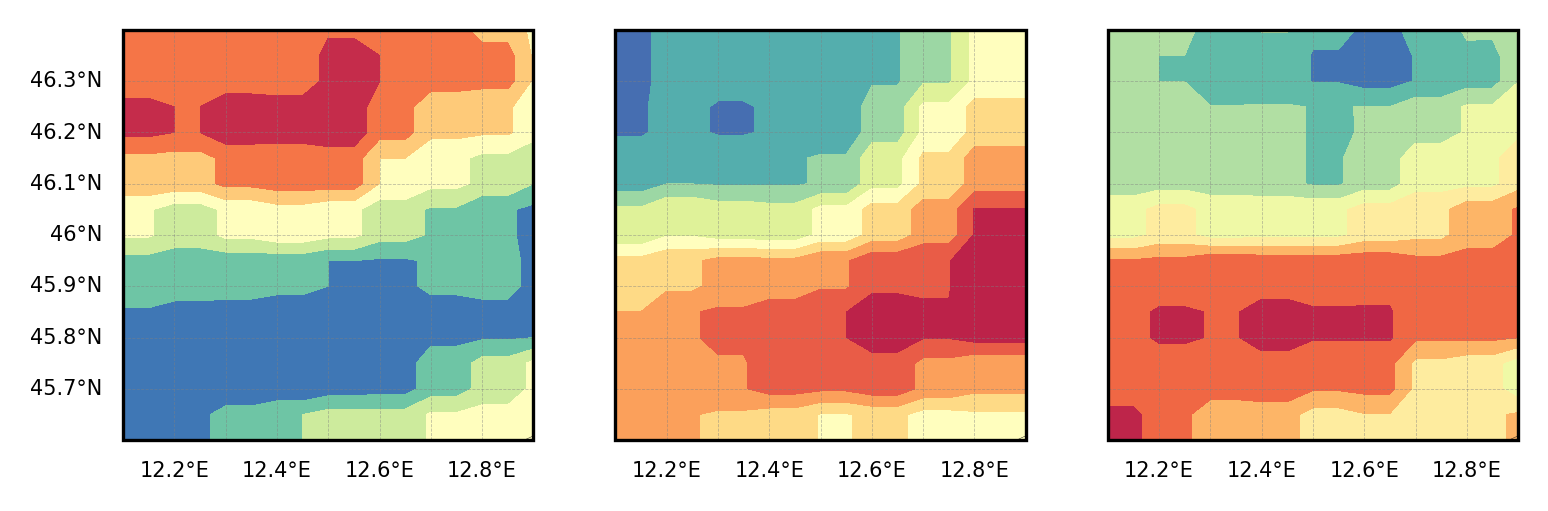

In [37]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,5),dpi=300)
gs = gridspec.GridSpec(1,3)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(lon2d,  lat2d, DOWN_xr.Nd, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(lon2d,  lat2d, DOWN_xr.Cs, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.contourf(lon2d,  lat2d, DOWN_xr.Wd, cmap=cmap)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

Text(1.0, 1.0, '(17, 17)')

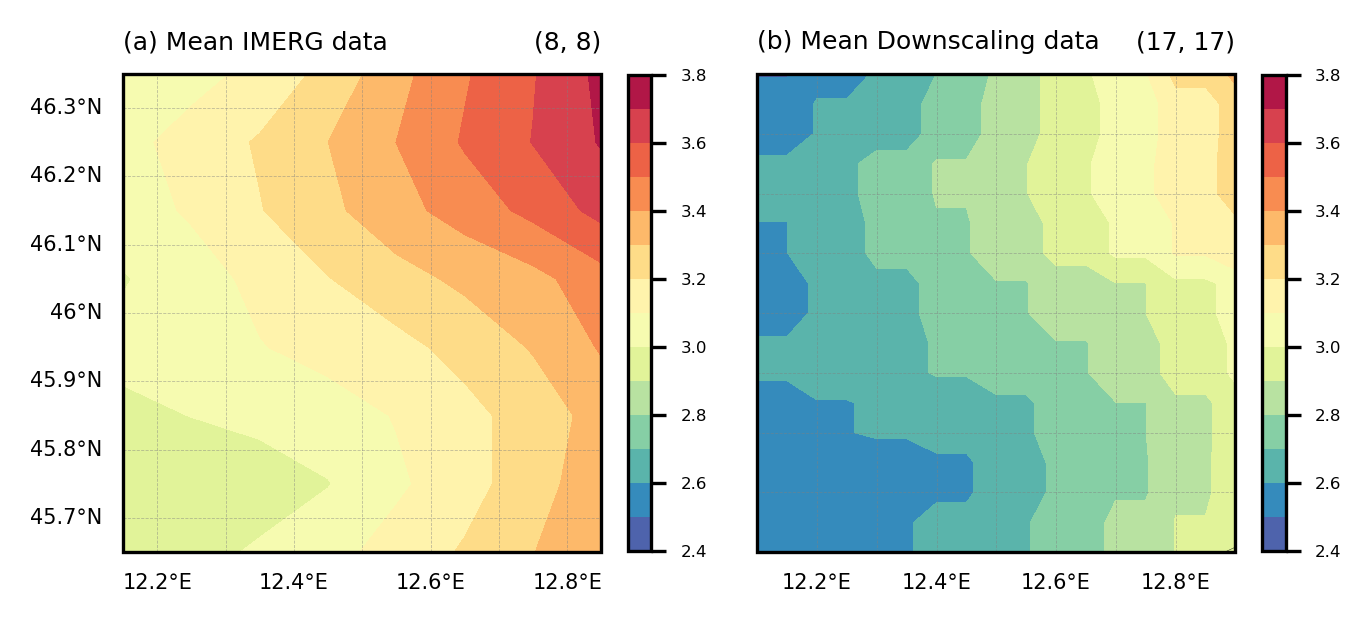

In [67]:
levels = np.arange(2.4, 3.9, 0.1)
# levels = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d_ref[1:-1,1:-1], lat2d_ref[1:-1,1:-1], np.mean(DATA['PRE'].values,axis=0)[1:-1,1:-1], cmap=cmap, levels=levels)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.045)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Mean IMERG data', loc='left', fontsize=6)
ax1.set_title(np.mean(DATA['PRE'].values,axis=0)[1:-1,1:-1].shape, loc='right', fontsize=6)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d,  lat2d, np.nanmean(RAIN_D,axis=0), cmap=cmap, levels=levels)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.045)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean Downscaling data', loc='left', fontsize=6)
ax1.set_title(np.nanmean(RAIN_D,axis=0).shape, loc='right', fontsize=6)

In [70]:
DATA['PRE'].shape

(3652, 10, 10)

Text(1.0, 1.0, '(17, 17)')

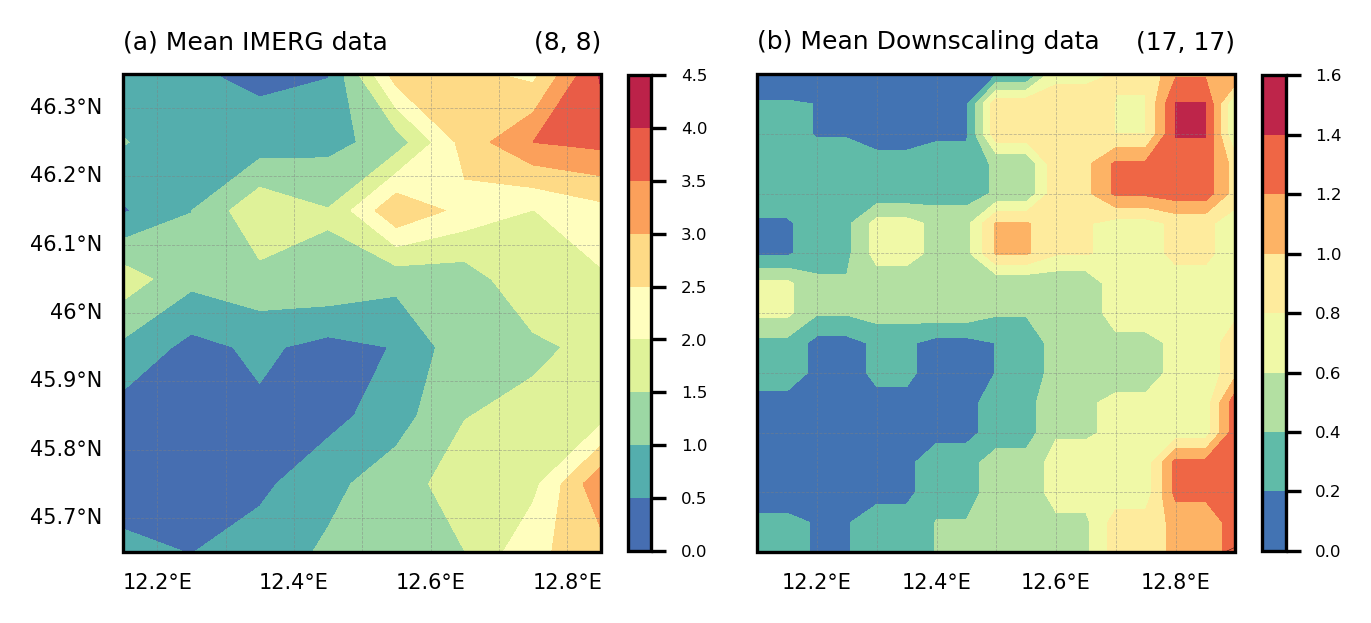

In [76]:
tt = 20

levels = np.arange(2.4, 3.9, 0.1)
levels = None

cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,5),dpi=300)
gs = gridspec.GridSpec(1,2)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d_ref[1:-1,1:-1], lat2d_ref[1:-1,1:-1], DATA['PRE'][tt,1:-1,1:-1], cmap=cmap, levels=levels)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.045)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(a) Mean IMERG data', loc='left', fontsize=6)
ax1.set_title(np.mean(DATA['PRE'].values,axis=0)[1:-1,1:-1].shape, loc='right', fontsize=6)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
# ax1.set_extent([-94, -90, 31, 34], crs=proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
a1 = ax1.contourf(lon2d,  lat2d, RAIN_D[tt,:,:], cmap=cmap, levels=levels)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 5, 'color': 'k'}
gl.ylabel_style = {'size': 5, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.045)
cbar.ax.tick_params(labelsize=4)

ax1.set_title('(b) Mean Downscaling data', loc='left', fontsize=6)
ax1.set_title(np.nanmean(RAIN_D,axis=0).shape, loc='right', fontsize=6)

In [48]:
lon2d_ref[1:-1].shape

(8, 10)